Set up GPU or CPU device.

In [1]:
import torch

# Setting device on GPU if available, else CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Additional Info on devices, when using cuda.
if device.type == 'cuda':
    for i in range(torch.cuda.device_count()):
        print()
        print('Device ',i)
        print(torch.cuda.get_device_name(i), round(torch.cuda.get_device_properties(i).total_memory/1024**3,1), 'GB')
        print('Memory Usage:')
        print('Allocated:  ', round(torch.cuda.memory_allocated(i)/1024**3,1), 'GB')
        print('Reserved:   ', round(torch.cuda.memory_reserved(i)/1024**3,1), 'GB')

Using device: cpu


#### Imports

In [46]:
import os
import io
import time
import copy
import importlib

import numpy as np
import matplotlib.pyplot as plt

import torchvision

import src.datasets
import src.transforms
import src.models
import src.utils

#### Dataset, transforms and augmentations

In [48]:
importlib.reload(src.datasets)
importlib.reload(src.transforms)

transforms = torchvision.transforms.Compose([
    src.transforms.MaskCrop(),
    src.transforms.PadToSquare(),
    src.transforms.Resize(224),
    src.transforms.ToTensor(),
    src.transforms.Normalize(),
])

tstart = time.time()
dataset = src.datasets.SingleCellDataset(csv_file='data/train_cells.csv', hdf5_file="data/train.hdf5",
                                        transform=transforms, test=False)
print(f"Initializing dataset took: {time.time()-tstart}")

Initializing dataset took: 558.1043691635132


### Performance Benchmarking

Check dataloader. Visualize one batch. (Note takes around 140s for ```batch_size=3``` and ```num_workers=0```)

In [49]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=12, collate_fn=src.datasets.collate_fn)
# Get a batch of training data (was ~240s from hdd.)
dataset._use_cache=False
tstart = time.time()
images, labels, annotations = next(iter(dataloader))
print(f"Loading one batch of {dataloader.batch_size} samples took: {time.time()-tstart}")
dataloader.dataset.set_use_cache()
tstart = time.time()
images, labels, annotations = next(iter(dataloader))
print(f"Loading one batch of {dataloader.batch_size} samples took: {time.time()-tstart}")

Loading one batch of 12 samples took: 7.896518707275391
Loading one batch of 12 samples took: 0.03514599800109863


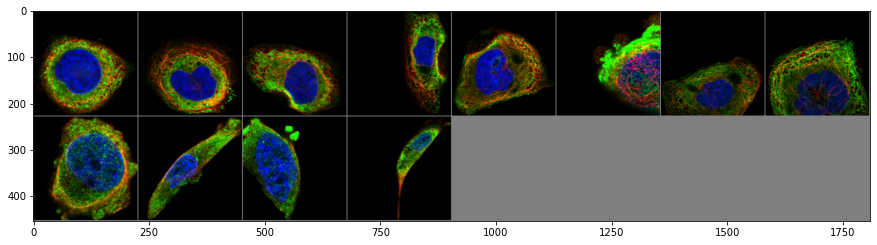

In [50]:
importlib.reload(src.utils)
# Make a grid from batch
out = torchvision.utils.make_grid(images)
plt.figure(figsize=(15,15))
src.utils.imshow(out)

#### Train Model Loop

In [144]:
import time
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            
            # Load images from cachhe
            if epoch == 1:
                dataset.set_use_cache()
                
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            with tqdm(dataloaders[phase], unit="batch") as tepoch:
                tepoch.set_description(f"Epoch {epoch+1}/{num_epochs} ({phase})")
                # Iterate over data.
                for images, labels, annotations in tepoch:
                    images = images.float().to(device)
                    labels = labels.float().to(device)

                    # zero the parameter gradients
                    #optimizer.zero_grad()  # Use nvidia approach instead.
                    for param in model.parameters():
                        param.grad = None

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(images)
                        #preds = nn.functional.threshold(outputs, threshold=0.6, value=0)
                        _, preds = torch.max(outputs,1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * images.size(0)
                    running_corrects += labels[:,preds].diag().numpy().sum()
                    
                    tepoch.set_postfix(loss=loss.item(), accuracy=labels[:,preds].diag().numpy().sum()/labels.shape[0])
                    time.sleep(0.001)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects / len(datasets[phase])
            
            tepoch.set_postfix(loss=epoch_loss, accuracy=epoch_acc)
            time.sleep(0.01)
            
            # save epoch
            if phase == 'test':
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': epoch_loss,
                    'acc': epoch_acc
                }, f"./models/model_{device.type}_{epoch}.pt")

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model, f"./models/model_{device_type}.pt")
                torch.save(model.state_dict(), f"./models/model_{device_type}_state.pt")


    time_elapsed = time.time() - since
    print("")
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

#### Design an appropriate loss function.

In [153]:
torch._C._nn.log_sigmoid
import torch.nn as nn
import torch.nn.functional as F

def weak_multilabel_soft_margin_loss(input, target, weight=None):
    loss = -(target * logsigmoid(input) + (1 - target) * logsigmoid(-input))
    if weight is not None:
        loss = loss * weight
    loss = loss.sum(dim=1) / input.size(1)  # only return N loss values
    ret = loss.mean()
    return ret


class WeakMultiLabelSoftMarginLoss(torch.nn.modules.loss._WeightedLoss):

    def __init__(self, weight):
        super(WeakMultiLabelSoftMarginLoss, self).__init__(weight)

    def forward(self, input):
        return F.multilabel_soft_margin_loss(input, target, weight=self.weight)

In [158]:
class HardMacroPrecision(nn.Module):
    '''Calculate Precision. Can work with gpu tensors
    
    The original implmentation is written by Michal Haltuf on Kaggle.
    
    Returns
    -------
    torch.Tensor
        `ndim` == 1. epsilon <= val <= 1
    
    Reference
    ---------
    - https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
    - https://discuss.pytorch.org/t/calculating-precision-recall-and-f1-score-in-case-of-multi-label-classification/28265/6
    - http://www.ryanzhang.info/python/writing-your-own-loss-function-module-for-pytorch/
    '''
    def __init__(self, threshold=0.5, epsilon=1e-7):
        super().__init__()
        self.threshold = threshold
        self.epsilon = epsilon
        
    def forward(self, y_pred, y_true,):
        assert y_pred.ndim == 2
        assert y_true.ndim == 1
        y_true = y_true.to(torch.float32)
        y_pred = F.threshold(y_pred, threshold=0.5, value=0)
        
        tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
        #tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
        #fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

        precision = tp / (tp + fp + self.epsilon)
        #recall = tp / (tp + fn + self.epsilon)

        #f1 = 2* (precision*recall) / (precision + recall + self.epsilon)
        precision = precision.clamp(min=self.epsilon, max=1-self.epsilon)
        return 1 - precision.mean()
    
class F1_Loss(nn.Module):
    '''Calculate F1 score. Can work with gpu tensors
    
    The original implmentation is written by Michal Haltuf on Kaggle.
    
    Returns
    -------
    torch.Tensor
        `ndim` == 1. epsilon <= val <= 1
    
    Reference
    ---------
    - https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
    - https://discuss.pytorch.org/t/calculating-precision-recall-and-f1-score-in-case-of-multi-label-classification/28265/6
    - http://www.ryanzhang.info/python/writing-your-own-loss-function-module-for-pytorch/
    '''
    def __init__(self, epsilon=1e-7):
        super().__init__()
        self.epsilon = epsilon
        
    def forward(self, y_pred, y_true,):
        y_pred = F.softmax(y_pred, dim=1)
        
        tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)

        f1 = 2* (precision*recall) / (precision + recall + self.epsilon)
        f1 = f1.clamp(min=self.epsilon, max=1-self.epsilon)
        return 1 - f1.mean()

#### Specify Model

In [159]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

# Resnet18 Model with first and last layer adapted
model_ft = torchvision.models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Freeze parameters.
for param in model_ft.parameters():
    param.requires_grad = False

# RGBY input
model_ft.conv1 = torch.nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# 19 class output
model_ft.fc = torch.nn.Linear(num_ftrs, 19)

model_ft = model_ft.float()
model_ft = model_ft.to(device)

# Loss function.
#criterion = torch.nn.MultiLabelSoftMarginLoss()
#criterion = HardMacroPrecision.cuda()
criterion = F1_Loss().cuda()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

#### Split Dataset int Train, Test, Val.

In [162]:
from torch.utils.data import Subset, DataLoader

dataset._use_cache=False

# Split dataset into Train and Validation set.
val_ratio = .15
val_len = int(np.floor(len(dataset)*val_ratio))
train, val = torch.utils.data.random_split(dataset, [len(dataset)-val_len, val_len], generator=torch.Generator().manual_seed(42))

# Subset trainset or Demo purposes.
train = Subset(train, range(30000))

# Split trainset into train and test sets.
test_ratio = .3
test_len = int(np.floor(len(train)*test_ratio))
train, test = torch.utils.data.random_split(train, [len(train)-test_len, test_len], generator=torch.Generator().manual_seed(42))
datasets = {"train": train, "test": test, "val": val}
dataloaders = {x: DataLoader(datasets[x], shuffle=True, batch_size=64, num_workers=6, collate_fn=src.datasets.collate_fn)
               for x in ["train", "test", "val"]}

#### Fit model.

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 1/25 (train):  19%|█▉        | 63/329 [12:06<56:15, 12.69s/batch, accuracy=0.234, loss=0.943]   

#### Create Sample Submission.

In [302]:
import pandas
sdf = pandas.read_csv("data/sample_submission.csv")
sdf['PredictionString'] = ""
sdf = sdf.set_index('ID')

In [303]:
ssdata = src.datasets.SingleCellDataset(csv_file='data/test_cells.csv', hdf5_file="data/test.hdf5",
                                        transform=transforms, test=True)
ssloader = torch.utils.data.DataLoader(ssdata, batch_size=64, num_workers=8, collate_fn=src.datasets.collate_fn)

In [304]:
def build_prediction_string(pred, conf, mask):
    mask = mask[2:-1]
    prediction_string = f"{pred} {conf} {mask}" 
    return prediction_string

In [305]:
with tqdm(ssloader, unit="batch") as tloader:
    tloader.set_description(f"Submission Sample")
    # Iterate over data.
    for images, labels, annotations in tloader:
        images = images.float().to(device)
        labels = labels.float().to(device)
        outputs = model_ft(images)
        #preds = nn.functional.threshold(1/(1+torch.exp(-outputs)), threshold=threshold, value=0)
        #confs, preds = torch.max(1/(1+torch.exp(-outputs)),1)
        batch_confs = 1/(1+torch.exp(-outputs))
        for confs, annotation in zip(batch_confs, annotations):
            iid = annotation['ID']
            rle = annotation['rle']
            npreds = 0
            for i, conf in enumerate(confs):
                if conf > 0.7:
                    pstring = build_prediction_string(i, conf, rle)
                    sdf.loc[iid, 'PredictionString'] = sdf.loc[iid, 'PredictionString'] + ' ' + pstring
                    npreds += 1
                if npreds == 0:
                    pstring = build_prediction_string(18, 0.7, rle)
                    sdf.loc[iid, 'PredictionString'] = sdf.loc[iid, 'PredictionString'] + ' ' + pstring

sdf = sdf.reset_index()
print(sdf.head())

Submission Sample: 100%|██████████| 168/168 [20:07<00:00,  7.19s/batch]

                                     ID  ImageWidth  ImageHeight  \
0  0040581b-f1f2-4fbe-b043-b6bfea5404bb        2048         2048   
1  004a270d-34a2-4d60-bbe4-365fca868193        2048         2048   
2  00537262-883c-4b37-a3a1-a4931b6faea5        2048         2048   
3  00c9a1c9-2f06-476f-8b0d-6d01032874a2        2048         2048   
4  0173029a-161d-40ef-af28-2342915b22fb        3072         3072   

                                    PredictionString  
0   0 0.9044561386108398 eNqtVm2PojAQ/ksMZe+Sy21y...  
1   0 0.816060483455658 eNoLCEhJMAgwDMg3NPQ39Df2t...  
2   0 0.8528010845184326 eNqFUE0LwjAM/UtJuqlM8AsU...  
3   0 0.8587595224380493 eNrtVUtvwjAM/ktxAutp2mGX...  
4   0 0.9091311097145081 eNqtlFuXmjAQgP8SDOgB2pee...  


In [306]:
import time
timestr = time.strftime("%Y%m%d-%H%M")
sdf.PredictionString = sdf.PredictionString.apply(lambda x: x.strip())
sdf.to_csv(f"./submissions/{timestr}_resnet_pred=07_loss=UNKNOWN_metric=acc_nsamples=30000.csv", index=False)

In [307]:
sdf.PredictionString[0].split(" ")

['0',
 '0.9044561386108398',
 'eNqtVm2PojAQ/ksMZe+Sy21yubtc4gKDIkpBUJQ3KyD//9t1KPhu1M22Rp9Op0+n0+mM87cMoj1osoHmgDN8aeCormcu7nBXgQ+ehxXWFczA9bDBPaF6ihPHrWECyRR/hTV4ulyuSLqm0GFMxOpDvRP18Ep+tynLSBV1RzGc8BzGg16HSIq67ArBrfnL9Zp2i/y2fHCXkg/EEndH0wZn4nGL83Un/cxvL5z/znmGbR/547j9q357wNPbeTj+eVfOUeZqzsl659RF2iFSDuMhWAaL5B79fB9lpOKPFk7p41Zbv9liAz9nMf6tN/Duxvin3UCiNRH+8lIotTxC7kQpCC2NcO4sU6i0dYSek6TQanGEYyeTMn0domcnOTT6MsSpneaw16MQJ3aeg8t4iI0lcghZG2BhuQUsWB1gbs0KiJgIMLN4ASuWB5hYUQEFiwMMrayAkoUBBlZZwJb5AXJrV4BgXoC+1RRQsUmAnjUuoWEtR9dyS2hZw3FseSVMDcGxNnkJcyPnKMy4BG5sOBZmUsLCWHHMzE0JsRFxTM28hKURcNyY2xJWxpzj2qxKSIwpoYbQmGbHW6nX+hK5W6lXE/JIdkSVL/lmhAQhn1BJsyGtyHzJFxNakywhFBPKCIWECkKc9MRW7jvzMTHrLWyMsY8rcyIkauYSTQlVhGYCMiOf49KMBOTGktBGwOrtXvx++fjiHb6s91y7l3de1X/Eczt5Xuq3H94c96wW0JohoULAxIoIZYSWhHgFv5k93MOQz5UHBmqnS1kOpQyFBtd1KUTJFTrVO0kql3KV3NTzv8Vzm79PF3i8mnNepUfcHT8yy+gTDHV1yK/x98M6dzduno2/z9z3M+1yv8lIPvjwW7SFdLQj5An4OMTDdWU949Gg/3dwpDyrC11A9ZbSrdwoCociYDObfe796Xhqb0+sQsEZ6u2V6x7Ux6vz3axbfeZ6or6ePBH5y